# PatchTST AB Test (Walmart) — Refactored Notebook

Variants:
- **A0**: y-only (no exogenous)
- **A1**: time/calendar exogenous (sin/cos)
- **A2**: time/calendar + holiday (vectorized, batch-safe)

Key fixes:
- `compose_exo_calendar_cb` supports **batched** `start_idx` so the DataLoader collate can call it once per batch.
- `get_train_loader(batch_size=...)` is called explicitly to avoid silent fallback to the default 32.


In [1]:
import os

import numpy as np
import polars as pl
import torch
import sys

# LTB modules (expected to exist in your repo)

# optional

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = "/Users/igwanhyeong/PycharmProjects/ts_forecaster_lib/raw_data/"
WINDOW_DIR = "C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/"

DIR = WINDOW_DIR if sys.platform == "win32" else MAC_DIR
device = "cuda" if torch.cuda.is_available() else "cpu"

print("DIR:", DIR)
print("device:", device)
if device == "cuda":
    print("cuda:", torch.version.cuda, "gpu_count:", torch.cuda.device_count())

DIR: C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/
device: cuda
cuda: 12.8 gpu_count: 1


In [2]:
df = pl.read_parquet(DIR + 'train_data/walmart_best_feature_train.parquet')
df

unique_id,date_idx,date,y,exo_is_holiday,exo_temperature,exo_fuel_price,exo_cpi,exo_unemployment,exo_markdown_sum,exo_markdown1,exo_markdown2,exo_markdown3,exo_markdown4,exo_markdown5,exo_markdown1_isnull,exo_markdown2_isnull,exo_markdown3_isnull,exo_markdown4_isnull,exo_markdown5_isnull,exo_p_y_lag_1w,exo_p_y_lag_2w,exo_p_y_lag_52w,exo_p_y_rollmean_4w,exo_p_y_rollmean_12w,exo_p_y_rollstd_4w,exo_p_weeks_since_holiday,exo_p_temperature,exo_p_fuel_price,exo_p_cpi,exo_p_unemployment,exo_p_markdown_sum,exo_p_markdown1,exo_p_markdown2,exo_p_markdown3,exo_p_markdown4,exo_p_markdown5,exo_c_woy_bucket
str,i64,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32
"""1""",14641,201005,1.6437e6,0.0,42.310001,2.572,211.096359,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,42.310001,2.572,211.096359,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14648,201006,1641957.5,1.0,38.509998,2.548,211.242172,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.6437e6,0.0,0.0,0.0,0.0,0.0,0.0,38.509998,2.548,211.242172,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14655,201007,1.6120e6,0.0,39.93,2.514,211.289139,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1641957.5,1.6437e6,0.0,0.0,0.0,0.0,1.0,39.93,2.514,211.289139,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14662,201008,1.4097e6,0.0,46.630001,2.561,211.319641,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.6120e6,1641957.5,0.0,1.576836e6,0.0,112353.398438,2.0,46.630001,2.561,211.319641,8.106,0.0,0.0,0.0,0.0,0.0,0.0,2
"""1""",14669,201009,1.5548e6,0.0,46.5,2.625,211.350143,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.4097e6,1.6120e6,0.0,1.554615e6,0.0,103135.0,3.0,46.5,2.625,211.350143,8.106,0.0,0.0,0.0,0.0,0.0,0.0,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",15607,201239,516361.0625,0.0,76.800003,3.666,226.763077,5.277,3711.670166,1699.680054,1.91,0.55,190.380005,1819.150024,0.0,0.0,0.0,0.0,0.0,533756.875,523427.34375,508567.03125,534839.375,536946.5625,21849.310547,3.0,76.800003,3.666,226.763077,5.277,3711.670166,1699.680054,1.91,0.55,190.380005,1819.150024,9
"""9""",15614,201240,606755.3125,0.0,66.610001,3.617,226.966232,4.954,5328.919922,2657.570068,0.0,3.01,1107.790039,1560.550049,0.0,1.0,0.0,0.0,0.0,516361.0625,533756.875,553837.0,545075.125,542798.0625,41735.964844,4.0,66.610001,3.617,226.966232,4.954,5328.919922,2657.570068,0.0,3.01,1107.790039,1560.550049,10
"""9""",15621,201241,558464.8125,0.0,60.09,3.601,227.169388,4.954,3366.26001,520.409973,0.0,6.01,0.0,2839.840088,0.0,1.0,0.0,1.0,0.0,606755.3125,516361.0625,529515.6875,553834.5,546504.1875,39282.828125,5.0,60.09,3.601,227.169388,4.954,3366.26001,520.409973,0.0,6.01,0.0,2839.840088,10


In [3]:
import random

past_exo_cont_cols = (
    # "exo_p_y_lag_1w",
    "exo_p_y_lag_2w",
    # "exo_p_y_lag_52w",
    "exo_p_y_rollmean_4w","exo_p_y_rollmean_12w","exo_p_y_rollstd_4w",
    # "exo_p_weeks_since_holiday`",
    # "exo_p_temperature",
    # "exo_p_fuel_price",
    # "exo_p_cpi",
    # "exo_p_unemployment",
    # "exo_p_markdown_sum",
    # "exo_p_markdown1",
    # "exo_p_markdown2",
    # "exo_p_markdown3",
    # "exo_p_markdown4",
    # "exo_p_markdown5",
    # "exo_markdown1_isnull",
    # "exo_markdown2_isnull",
    # "exo_markdown3_isnull",
    # "exo_markdown4_isnull",
    # "exo_markdown5_isnull",
)
past_exo_cat_cols = (
    # "exo_c_woy_bucket",
)

lookback = 52
horizon = 27
batch_size = 256

freq = "weekly"          # walmart dt is weekly
split_mode = "multi"     # id-disjoint split (leakage-safe)
shuffle = True

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("high")

print("device:", device)


device: cuda


In [4]:

from modeling_module.utils.exogenous_utils import compose_exo_calendar_cb

future_exo_cb_time = compose_exo_calendar_cb(date_type=freq)

# ============================================================
# Holiday lookup (vectorized) + FutureExo callback (time + holiday)
# ============================================================
holiday_map_dayidx = {
    int(row[0]): float(row[1])
    for row in (
        df.select(["date_idx", "exo_is_holiday"])
          .group_by("date_idx")
          .agg(pl.max("exo_is_holiday").alias("exo_is_holiday"))
          .sort("date_idx")
          .iter_rows()
    )
}

def build_holiday_array(holiday_map_dayidx: dict[int, float], *, pad: int = 0) -> np.ndarray:
    if not holiday_map_dayidx:
        return np.zeros((1,), dtype=np.float32)
    max_k = max(int(k) for k in holiday_map_dayidx.keys())
    arr = np.zeros((max_k + 1 + int(pad),), dtype=np.float32)
    for k, v in holiday_map_dayidx.items():
        kk = int(k)
        if kk >= 0:
            arr[kk] = float(v)
    return arr

class FutureExoTimePlusHoliday:
    def __init__(self, holiday_by_dayidx: np.ndarray, *, step_days: int = 7):
        self.holiday = holiday_by_dayidx.astype(np.float32, copy=False)
        self.step_days = int(step_days)

    def __call__(self, start_idx, H: int, device: str = "cpu"):
        # 1) calendar exo (batch-safe)
        cal = future_exo_cb_time(start_idx, H, device=device)  # scalar: (H,E) | batch: (B,H,E)

        # 2) holiday exo (vectorized in numpy)
        is_scalar = isinstance(start_idx, (int, np.integer))
        if is_scalar:
            s = np.asarray([int(start_idx)], dtype=np.int64)
        else:
            s = np.asarray(start_idx, dtype=np.int64).reshape(-1)

        B = s.shape[0]
        H = int(H)

        offsets = (self.step_days * np.arange(H, dtype=np.int64))[None, :]  # (1,H)
        idx = s[:, None] + offsets                                          # (B,H)

        hol = np.zeros((B, H), dtype=np.float32)
        valid = (idx >= 0) & (idx < self.holiday.shape[0])
        hol[valid] = self.holiday[idx[valid]]
        hol_t = torch.from_numpy(hol).unsqueeze(-1)                         # (B,H,1), CPU

        target_device = cal.device  # cal이 이미 cuda일 수 있음
        cal = cal.to(target_device, dtype=torch.float32)
        hol_t = hol_t.to(target_device, dtype=torch.float32)

        # 3) concat
        if is_scalar:
            out = torch.cat([cal.to(torch.float32).unsqueeze(0), hol_t], dim=-1)[0]  # (H,E+1)
        else:
            out = torch.cat([cal.to(torch.float32), hol_t], dim=-1)                  # (B,H,E+1)

        return out

holiday_by_dayidx = build_holiday_array(holiday_map_dayidx, pad=7 * (horizon + 2))
future_exo_cb_time_plus_holiday = FutureExoTimePlusHoliday(holiday_by_dayidx, step_days=7)


In [5]:
import importlib, inspect
m = importlib.import_module("modeling_module.models.PatchTST.supervised.PatchTST")

print("[PatchTST module file]", m.__file__)
print("[DistHeadWithExo class]", m.DistHeadWithExo)
print("[DistHeadWithExo forward file]", inspect.getsourcefile(m.DistHeadWithExo.forward))
print("[DistHeadWithExo forward sig ]", inspect.signature(m.DistHeadWithExo.forward))

[PatchTST module file] C:\Users\USER\PycharmProjects\ts_forecaster_lib\src\modeling_module\models\PatchTST\supervised\PatchTST.py
[DistHeadWithExo class] <class 'modeling_module.models.PatchTST.supervised.PatchTST.DistHeadWithExo'>
[DistHeadWithExo forward file] C:\Users\USER\PycharmProjects\ts_forecaster_lib\src\modeling_module\models\PatchTST\supervised\PatchTST.py
[DistHeadWithExo forward sig ] (self, h: torch.Tensor, future_exo: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]


In [6]:



from modeling_module.utils.metrics import mae, rmse, smape
from modeling_module.utils.eval_utils import eval_on_loader, eval_on_loader_quantile
from modeling_module.utils.checkpoint import load_model_dict
from modeling_module.models import build_patchTST_quantile, build_patchTST_base
from modeling_module.training.model_trainers.total_train import run_total_train_weekly
from modeling_module.data_loader import MultiPartExoDataModule
import pandas as pd
rows = []  # seed loop 밖에서 선언

def set_seed(seed: int = 11):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    elif torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def build_datamodule(variant: str, seed: int) -> MultiPartExoDataModule:
    if variant == "A0":
        future_exo_cb = None
    elif variant == "A1":
        future_exo_cb = future_exo_cb_time
    elif variant == "A2":
        future_exo_cb = future_exo_cb_time_plus_holiday
    else:
        raise ValueError(variant)

    return MultiPartExoDataModule(
        df=df,
        id_col="unique_id",
        date_col="date",
        y_col="y",
        lookback=lookback,
        horizon=horizon,
        batch_size=batch_size,
        past_exo_cont_cols=past_exo_cont_cols,
        past_exo_cat_cols=past_exo_cat_cols,
        future_exo_cb=future_exo_cb,
        freq=freq,
        shuffle=shuffle,
        split_mode=split_mode,
        seed=seed,
    )

def inspect(loader, name):
    b = next(iter(loader))
    x, y, uid, fe, pe_cont, pe_cat = b
    print(f"[{name}] x:", x.shape, x.device, x.dtype)
    print(f"[{name}] fe:", fe.shape, fe.device, fe.dtype)
    print(f"[{name}] pe:", pe_cont.shape, pe_cont.device, pe_cont.dtype)
    print(f"[{name}] future_exo_cb is None?", loader.collate_fn.future_exo_cb is None)
    if fe.shape[-1] > 0:
        print(f"[{name}] fe sample:", fe[0, :3, :])

# seed_list = [11, 22, 33, 44, 55]
seed_list = [55]
for seed in seed_list:
    set_seed(seed)

    save_dir = os.path.join(DIR, "fit", "walmart_patchtst_ab")
    os.makedirs(save_dir, exist_ok=True)

    save_root_A0 = os.path.join(save_dir, "A0_y_only", f"seed_{seed}")
    save_root_A1 = os.path.join(save_dir, "A1_time_exog", f"seed_{seed}")
    save_root_A2 = os.path.join(save_dir, "A2_time_holiday", f"seed_{seed}")

    data_module_A0 = build_datamodule("A0", seed)
    data_module_A1 = build_datamodule("A1", seed)
    data_module_A2 = build_datamodule("A2", seed)

    train_loader_A0 = data_module_A0.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A0   = data_module_A0.get_val_loader()

    train_loader_A1 = data_module_A1.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A1   = data_module_A1.get_val_loader()

    train_loader_A2 = data_module_A2.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A2   = data_module_A2.get_val_loader()

    inspect(train_loader_A0, "A0")
    inspect(train_loader_A1, "A1")
    inspect(train_loader_A2, "A2")

    # ============================================
    # 학습 실행 (LTB total_train 포맷 유지)
    # - 여기서는 "외생변수 A/B/C"만 비교하므로 use_ssl_pretrain=False로 고정
    # Walmart처럼 항상 판매량이 있는(continuous) 데이터에서 “스파이크”를 잡는 규칙이:
    # 스파이크 마스크가 과도하게 넓게 잡히거나(사실상 대부분 True)
    # spike-loss가 MSE/제곱오차 기반인데 reduction이 sum 또는 정규화 없이 누적되어
    # sales 스케일(1e4~1e5)에서 제곱오차가 1e8급으로 바로 올라가
    # → 결과적으로 delta가 1e8 수준으로 튄다.
    # → 그래서 최종적으로 이 상황에서는 spike_epoch를 0으로 잡아준다.
    # ============================================
    # DistributionLoss(distribution="StudentT", level=[80, 90]),
    print('run result_A0')
    results_A0 = run_total_train_weekly(
        train_loader_A0,
        val_loader_A0,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=20,
        spike_epochs=0,
        save_dir=save_root_A0,
        models_to_run=["patchtst"],
        use_ssl_mode = 'full',
        point_loss_mode="dist",
    )

    print('run result_A1')
    results_A1 = run_total_train_weekly(
        train_loader_A1,
        val_loader_A1,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=20,
        spike_epochs=0,
        save_dir=save_root_A1,
        use_exogenous_mode = True,
        models_to_run=["patchtst"],
        use_ssl_mode = 'full',
        point_loss_mode="dist",
    )

    print('run result_A2')
    results_A2 = run_total_train_weekly(
        train_loader_A2,
        val_loader_A2,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=20,
        spike_epochs=0,
        save_dir=save_root_A2,
        use_exogenous_mode = True,
        models_to_run=["patchtst"],
        use_ssl_mode = 'full',
        point_loss_mode="dist",
    )

    builders = {
    "patchtst_quantile": build_patchTST_quantile,
    "patchtst": build_patchTST_base,
    }

    print(load_model_dict(save_root_A0, builders, device = device))

    model_A0 = load_model_dict(save_root_A0, builders, device = device)['patchtst']
    model_A1 = load_model_dict(save_root_A1, builders, device = device)['patchtst']
    model_A2 = load_model_dict(save_root_A2, builders, device = device)['patchtst']

    y0, yhat0 = eval_on_loader(model_A0, val_loader_A0, device=device)
    y1, yhat1 = eval_on_loader(model_A1, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
    y2, yhat2 = eval_on_loader(model_A2, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

    metric_A0 = {
    "MAE": float(mae(y0.reshape(-1), yhat0.reshape(-1))),
    "RMSE": float(rmse(y0.reshape(-1), yhat0.reshape(-1))),
    "SMAPE": float(smape(y0.reshape(-1), yhat0.reshape(-1))),
    }
    metric_A1 = {
        "MAE": float(mae(y1.reshape(-1), yhat1.reshape(-1))),
        "RMSE": float(rmse(y1.reshape(-1), yhat1.reshape(-1))),
        "SMAPE": float(smape(y1.reshape(-1), yhat1.reshape(-1))),
    }
    metric_A2 = {
        "MAE": float(mae(y2.reshape(-1), yhat2.reshape(-1))),
        "RMSE": float(rmse(y2.reshape(-1), yhat2.reshape(-1))),
        "SMAPE": float(smape(y2.reshape(-1), yhat2.reshape(-1))),
    }

    model_A0_q = load_model_dict(save_root_A0, builders, device = device)['patchtst_quantile']
    model_A1_q = load_model_dict(save_root_A1, builders, device = device)['patchtst_quantile']
    model_A2_q = load_model_dict(save_root_A2, builders, device = device)['patchtst_quantile']

    y0_q, yhat0_q = eval_on_loader_quantile(model_A0_q, val_loader_A0, device=device)
    y1_q, yhat1_q = eval_on_loader_quantile(model_A1_q, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
    y2_q, yhat2_q = eval_on_loader_quantile(model_A2_q, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

    metric_A0_q = {
    "MAE": float(mae(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    "RMSE": float(rmse(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    "SMAPE": float(smape(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    }
    metric_A1_q = {
        "MAE": float(mae(y1_q.reshape(-1), yhat1_q.reshape(-1))),
        "RMSE": float(rmse(y1_q.reshape(-1), yhat1_q.reshape(-1))),
        "SMAPE": float(smape(y1_q.reshape(-1), yhat1_q.reshape(-1))),
    }
    metric_A2_q = {
        "MAE": float(mae(y2_q.reshape(-1), yhat2_q.reshape(-1))),
        "RMSE": float(rmse(y2_q.reshape(-1), yhat2_q.reshape(-1))),
        "SMAPE": float(smape(y2_q.reshape(-1), yhat2_q.reshape(-1))),
    }

    # -------------------------
    # Point metrics row append
    # -------------------------
    rows.append({
        "seed": seed,
        "variant": "A0",
        "model_type": "point",
        "MAE": metric_A0["MAE"],
        "RMSE": metric_A0["RMSE"],
        "SMAPE": metric_A0["SMAPE"],
        "save_root": save_root_A0,
    })
    rows.append({
        "seed": seed,
        "variant": "A1",
        "model_type": "point",
        "MAE": metric_A1["MAE"],
        "RMSE": metric_A1["RMSE"],
        "SMAPE": metric_A1["SMAPE"],
        "save_root": save_root_A1,
    })
    rows.append({
        "seed": seed,
        "variant": "A2",
        "model_type": "point",
        "MAE": metric_A2["MAE"],
        "RMSE": metric_A2["RMSE"],
        "SMAPE": metric_A2["SMAPE"],
        "save_root": save_root_A2,
    })

    # -------------------------
    # Quantile metrics row append
    # (주의: q50 등 기준이 명확해야 함)
    # -------------------------
    rows.append({
        "seed": seed,
        "variant": "A0",
        "model_type": "quantile(q50)",
        "MAE": metric_A0_q["MAE"],
        "RMSE": metric_A0_q["RMSE"],
        "SMAPE": metric_A0_q["SMAPE"],
        "save_root": save_root_A0,
    })
    rows.append({
        "seed": seed,
        "variant": "A1",
        "model_type": "quantile(q50)",
        "MAE": metric_A1_q["MAE"],
        "RMSE": metric_A1_q["RMSE"],
        "SMAPE": metric_A1_q["SMAPE"],
        "save_root": save_root_A1,
    })
    rows.append({
        "seed": seed,
        "variant": "A2",
        "model_type": "quantile(q50)",
        "MAE": metric_A2_q["MAE"],
        "RMSE": metric_A2_q["RMSE"],
        "SMAPE": metric_A2_q["SMAPE"],
        "save_root": save_root_A2,
    })

# loop 종료 후 저장
df_out = pd.DataFrame(rows)

out_csv = os.path.join(save_dir, "ab_results_by_seed.csv")
df_out.to_csv(out_csv, index=False)

# variant별 mean/std 요약도 같이 저장 추천
summary = (
    df_out.groupby(["variant", "model_type"])[["MAE", "RMSE", "SMAPE"]]
    .agg(["mean", "std"])
    .reset_index()
)
out_sum = os.path.join(save_dir, "ab_results_summary.csv")
summary.to_csv(out_sum, index=False)

print("saved:", out_csv, out_sum)


[A0] x: torch.Size([256, 52, 1]) cpu torch.float32
[A0] fe: torch.Size([256, 27, 0]) cpu torch.float32
[A0] pe: torch.Size([256, 52, 4]) cpu torch.float32
[A0] future_exo_cb is None? True
[A1] x: torch.Size([256, 52, 1]) cpu torch.float32
[A1] fe: torch.Size([256, 27, 2]) cpu torch.float32
[A1] pe: torch.Size([256, 52, 4]) cpu torch.float32
[A1] future_exo_cb is None? False
[A1] fe sample: tensor([[-0.7468,  0.6651],
        [-0.6624,  0.7491],
        [-0.5671,  0.8237]])
[A2] x: torch.Size([256, 52, 1]) cpu torch.float32
[A2] fe: torch.Size([256, 27, 3]) cpu torch.float32
[A2] pe: torch.Size([256, 52, 4]) cpu torch.float32
[A2] future_exo_cb is None? False
[A2] fe sample: tensor([[0.8859, 0.4639, 0.0000],
        [0.9355, 0.3534, 0.0000],
        [0.9708, 0.2398, 0.0000]])
run result_A0
use_exogenous_mode::  False
has_fe::  True
fe_dim::  0

[total_train] === RUN: patchtst (weekly) ===
point_train_cfg:  TrainingConfig(device='cuda', log_every=100, use_amp=True, lookback=52, horizon=2

In [7]:
# ============================================
# CELL 6) 체크포인트 로드 + 평가 (첨부 노트북 흐름 유지)
# - quantile 모델이면 eval_on_loader_quantile 사용
# - point 모델이면 eval_on_loader 사용
# ============================================

# builders는 "당신이 실제 저장한 모델 키"에 맞추세요.
# (첨부 노트북에서는 patchtst_quantile을 사용)
# builders = {
#     "patchtst_quantile": build_patchTST_quantile,
#     "patchtst": build_patchTST_base,
# }

# model_A0 = load_model_dict(save_root_A0, builders, device = device)['patchtst_quantile']
# model_A1 = load_model_dict(save_root_A1, builders, device = device)['patchtst_quantile']
# model_A2 = load_model_dict(save_root_A2, builders, device = device)['patchtst_quantile']

model_A0 = load_model_dict(save_root_A0, builders, device = device)['patchtst']
model_A1 = load_model_dict(save_root_A1, builders, device = device)['patchtst']
model_A2 = load_model_dict(save_root_A2, builders, device = device)['patchtst']

# 첨부 노트북에서 사용하던 eval 유틸을 그대로 쓴다고 가정합니다.
# (이미 앞 셀에 정의돼 있거나, 별도 모듈에 있으면 import 하세요.)
# from your_notebook_utils import eval_on_loader_quantile

# y0, yhat0 = eval_on_loader_quantile(model_A0, val_loader_A0, device, prefer_q=0.5)
# y1, yhat1 = eval_on_loader_quantile(model_A1, val_loader_A1, device, prefer_q=0.5, future_exo_cb = future_exo_cb_time)
# y2, yhat2 = eval_on_loader_quantile(model_A2, val_loader_A2, device, prefer_q=0.5, future_exo_cb = future_exo_cb_time_plus_holiday)

y0, yhat0 = eval_on_loader(model_A0, val_loader_A0, device=device)
y1, yhat1 = eval_on_loader(model_A1, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
y2, yhat2 = eval_on_loader(model_A2, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

metric_A0 = {
    "MAE": float(mae(y0.reshape(-1), yhat0.reshape(-1))),
    "RMSE": float(rmse(y0.reshape(-1), yhat0.reshape(-1))),
    "SMAPE": float(smape(y0.reshape(-1), yhat0.reshape(-1))),
}
metric_A1 = {
    "MAE": float(mae(y1.reshape(-1), yhat1.reshape(-1))),
    "RMSE": float(rmse(y1.reshape(-1), yhat1.reshape(-1))),
    "SMAPE": float(smape(y1.reshape(-1), yhat1.reshape(-1))),
}
metric_A2 = {
    "MAE": float(mae(y2.reshape(-1), yhat2.reshape(-1))),
    "RMSE": float(rmse(y2.reshape(-1), yhat2.reshape(-1))),
    "SMAPE": float(smape(y2.reshape(-1), yhat2.reshape(-1))),
}
print(f'metric_A0: {metric_A0}')
print(f'metric_A1: {metric_A1}')
print(f'metric_A2: {metric_A2}')
# metric_A0, metric_A1, metric_A2

[load] patchtst_quantile ← C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/fit\walmart_patchtst_ab\A0_y_only\seed_55\weekly_PatchTSTQuantile_L52_H27.pt
[DBG-backbone-init] d_past_cont=0 cont_input_dim=0 target_input_dim=12 total_input_dim=12
[load] patchtst ← C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/fit\walmart_patchtst_ab\A0_y_only\seed_55\weekly_PatchTSTBase_L52_H27.pt
[DBG-backbone-init] d_past_cont=0 cont_input_dim=0 target_input_dim=12 total_input_dim=12
[load][patchtst] missing=2 unexpected=4
  missing sample: ['head.proj.weight', 'head.proj.bias']
  unexpected sample: ['head.loc_head.weight', 'head.loc_head.bias', 'head.scale_head.weight', 'head.scale_head.bias']
[load] patchtst_quantile ← C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/fit\walmart_patchtst_ab\A1_time_exog\seed_55\weekly_PatchTSTQuantile_L52_H27.pt
[DBG-backbone-init] d_past_cont=0 cont_input_dim=0 target_input_dim=12 total_input_dim=12
[load] patchtst ← C:/Users/USER/PycharmPro

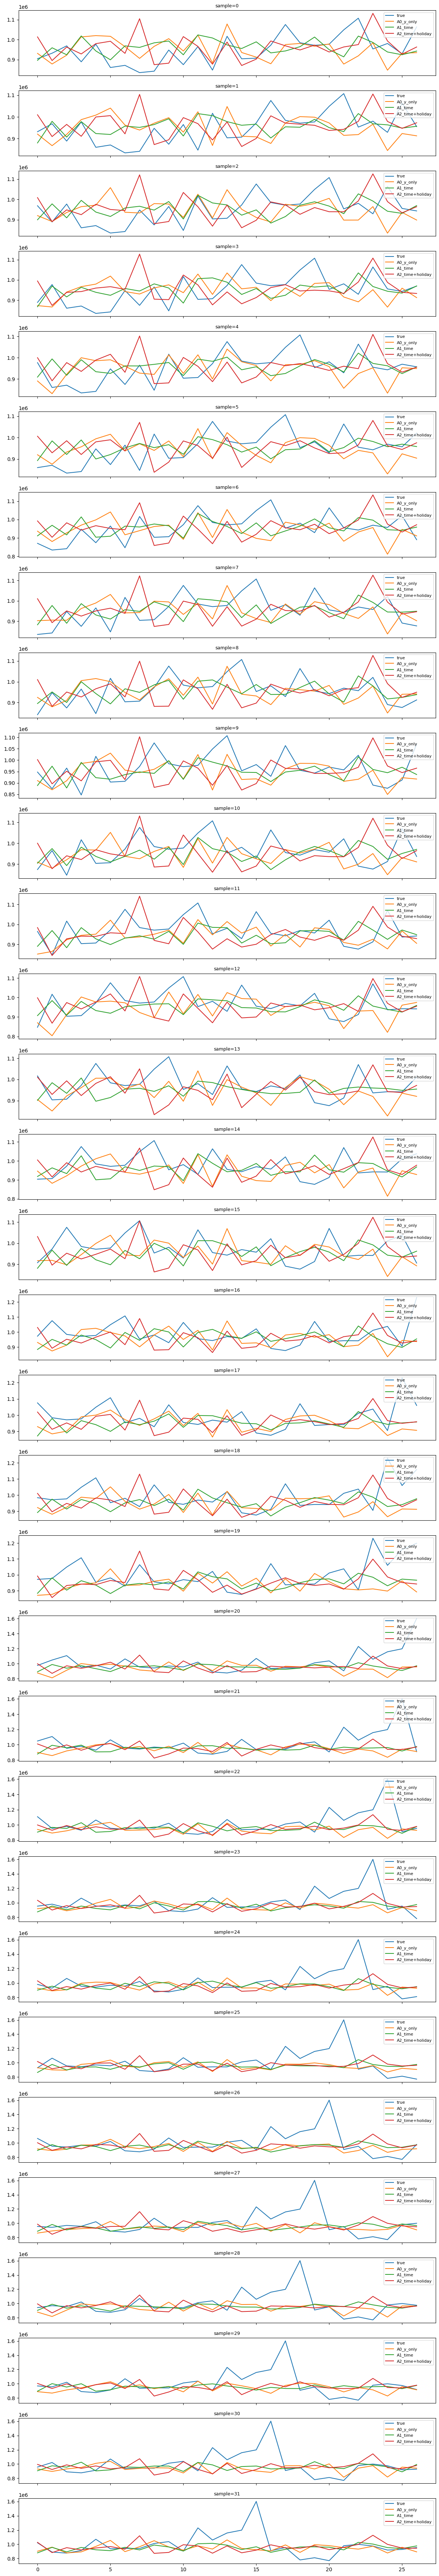

In [8]:
# ============================================
# CELL 7) (선택) 예측 시각화 (첨부 노트북 스타일)
# ============================================
import matplotlib.pyplot as plt

def plot_samples(y_true, preds: dict, max_n: int = 64):
    n = min(max_n, y_true.shape[0])
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 2.2*n), sharex=True)

    if n == 1:
        axes = [axes]

    for i in range(n):
        ax = axes[i]
        ax.plot(y_true[i], label="true")
        for k, v in preds.items():
            ax.plot(v[i], label=k)
        ax.set_title(f"sample={i}", fontsize=9)
        ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_samples(
    y_true=y0,
    preds={
        "A0_y_only": yhat0,
        "A1_time": yhat1,
        "A2_time+holiday": yhat2,
    },
    max_n=32,
)

In [ ]:
from modeling_module.training.forecater import DMSForecaster

import random
import numpy as np
import pandas as pd
import polars as pl
import torch
import matplotlib.pyplot as plt

from modeling_module.utils.date_util import DateUtil

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST as NixtlaPatchTST
from neuralforecast.losses.pytorch import DistributionLoss


# =========================
# 0) Reproducibility
# =========================
def set_seed(seed: int = 22):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(55)


# =========================
# 1) Config
# =========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = 27
LOOKBACK = 52
PATCH_LEN = 24
STRIDE = 24
FREQ = "W-MON"

PARQUET_PATH = DIR + "train_data/walmart_best_feature_train.parquet"

# our_model
our_model = model_A0
our_model.eval()
forecaster = DMSForecaster(our_model)


# =========================
# 2) Load polars -> pandas (Nixtla format)
# =========================
df = pl.read_parquet(PARQUET_PATH)

# DateUtil을 통일해서 사용 (DateUtil.yyyyww_to_date)
nixtla_df = (
    df.select(["unique_id", "date", "y"])
      .with_columns([
          pl.col("unique_id").cast(pl.Utf8),
          pl.col("date").map_elements(DateUtil.yyyyww_to_date, return_dtype=pl.Date).alias("ds"),
          pl.col("y").cast(pl.Float64),
      ])
      .select(["unique_id", "ds", "y"])
      .sort(["unique_id", "ds"])
      .to_pandas()
)
nixtla_df["ds"] = pd.to_datetime(nixtla_df["ds"])
nixtla_df["unique_id"] = nixtla_df["unique_id"].astype(str)

print("[debug] raw unique_id:", nixtla_df["unique_id"].nunique())
print("[debug] raw ds range:", nixtla_df["ds"].min(), "~", nixtla_df["ds"].max())


# =========================
# 3) Weekly reindex (안전 버전)
#    - 같은 ds에 중복 row가 있으면 sum으로 집계 후 reindex
# =========================
def reindex_weekly_panel_sum(df_: pd.DataFrame, freq: str = "W-MON") -> pd.DataFrame:
    out = []
    for uid, g in df_.groupby("unique_id", sort=False):
        g = g.sort_values("ds")

        # (중요) 중복 ds를 sum으로 집계 (데이터에 중복 주차가 있으면 reindex가 꼬임)
        g = g.groupby("ds", as_index=False)["y"].sum()

        idx = pd.date_range(start=g["ds"].min(), end=g["ds"].max(), freq=freq)
        gg = g.set_index("ds").reindex(idx)
        gg.index.name = "ds"
        gg = gg.reset_index()
        gg["unique_id"] = uid
        gg["y"] = gg["y"].fillna(0.0)

        out.append(gg[["unique_id", "ds", "y"]])
    return pd.concat(out, ignore_index=True)

nixtla_df = reindex_weekly_panel_sum(nixtla_df, freq=FREQ)

print("[debug] after reindex unique_id:", nixtla_df["unique_id"].nunique())
print("[debug] after reindex ds freq check sample:")
tmp = nixtla_df[nixtla_df["unique_id"] == nixtla_df["unique_id"].iloc[0]].sort_values("ds")
print(tmp["ds"].diff().dropna().value_counts().head(3))


# =========================
# 4) Length filter (여기가 0 만들기 가장 흔한 포인트)
# =========================
# val_size=H를 쓰면 train에 최소 (LOOKBACK + H)가 필요하고
# holdout test로 H를 따로 빼니 전체는 LOOKBACK + 2H가 "권장"이지만,
# 데이터가 짧다면 우선 완화해서 돌리는 게 맞습니다.
MIN_REQUIRED = LOOKBACK + H  # <-- 완화 (기존 LOOKBACK + 2H -> 너무 빡빡해서 0될 가능성 큼)

lens = nixtla_df.groupby("unique_id")["y"].size().sort_values()
valid_ids = lens[lens >= (MIN_REQUIRED + H)].index  # train에 LOOKBACK+H, test에 H => total >= LOOKBACK+2H
# 만약 여기서도 0이면, 아래 줄을 더 완화:
# valid_ids = lens[lens >= (LOOKBACK + H)].index

panel = nixtla_df[nixtla_df["unique_id"].isin(valid_ids)].copy()

print("[debug] valid_ids:", len(valid_ids))
if len(valid_ids) == 0:
    print("[debug] shortest series length top5:\n", lens.head(5))
    print("[debug] longest series length top5:\n", lens.tail(5))
    raise RuntimeError(
        "No valid_ids remain after length filtering. "
        "Lower LOOKBACK/H or relax MIN_REQUIRED condition."
    )


# =========================
# 5) Holdout split (last H as test)
# =========================
def split_last_h(df_: pd.DataFrame, h: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_ = df_.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    test = df_.groupby("unique_id", group_keys=False).tail(h)
    train = df_.drop(test.index)
    return train.reset_index(drop=True), test.reset_index(drop=True)

train_df, test_df = split_last_h(panel, h=H)

print("[debug] train unique_id:", train_df["unique_id"].nunique(), "rows:", len(train_df))
print("[debug] test  unique_id:", test_df["unique_id"].nunique(), "rows:", len(test_df))

if train_df["unique_id"].nunique() == 0:
    raise RuntimeError("train_df has zero groups. Check filtering/splitting logic.")

futr_df = test_df[["unique_id", "ds"]].copy()


# =========================
# 6) Nixtla PatchTST train + predict (holdout ds 사용)
# =========================
nixtla_model = NixtlaPatchTST(
    h=H,
    input_size=LOOKBACK,
    patch_len=PATCH_LEN,
    stride=STRIDE,
    hidden_size=16,
    n_heads=4,
    start_padding_enabled=True,

    scaler_type="standard",
    revin=True,

    loss=DistributionLoss(distribution="StudentT", level=[80, 90]),
    learning_rate=1e-3,
    max_steps=500,
    val_check_steps=50,
    early_stop_patience_steps=2,

    accelerator="gpu" if DEVICE == "cuda" else "cpu",
    devices=1,
    enable_progress_bar=False,
)

nf = NeuralForecast(models=[nixtla_model], freq=FREQ)

# (중요) train이 짧다면 val_size=H가 다시 문제를 만들 수 있음 -> 안전하게 0으로도 가능
val_size = H if (train_df.groupby("unique_id")["y"].size().min() >= (LOOKBACK + H)) else 0
print("[debug] using val_size =", val_size)

nf.fit(df=train_df, val_size=val_size)

fcst_nf = nf.predict(futr_df=futr_df).reset_index(drop=False)

# 예측 컬럼명 추출 (DistributionLoss면 PatchTST-median이 있을 수도 있음)
pred_cols = [c for c in fcst_nf.columns if c.startswith("PatchTST")]
NI_COL = "PatchTST-median" if "PatchTST-median" in pred_cols else "PatchTST"
print("[debug] nixtla pred col:", NI_COL)


# =========================
# 7) Our predict (DMSForecaster)
# =========================
our_rows = []
for uid, g_tr in train_df.groupby("unique_id", sort=False):
    g_tr = g_tr.sort_values("ds")
    y_hist = g_tr["y"].to_numpy(dtype=np.float32)

    # 마지막 LOOKBACK window
    x_win = y_hist[-LOOKBACK:]
    x_t = torch.from_numpy(x_win).unsqueeze(0)  # (1, LOOKBACK)

    out = forecaster.predict(x_t, horizon=H, device=DEVICE, mode="eval", future_exo_cb = future_exo_cb_time)
    y_hat = np.asarray(out["point"], dtype=np.float32).reshape(-1)

    g_te = test_df[test_df["unique_id"] == uid].sort_values("ds")
    ds_te = g_te["ds"].to_list()
    y_te = g_te["y"].to_numpy(dtype=np.float32)

    if len(ds_te) != H:
        raise RuntimeError(f"uid={uid} test length != H. got {len(ds_te)}")

    for d, yt, yp in zip(ds_te, y_te, y_hat):
        our_rows.append((uid, d, float(yt), float(yp)))

our_df = pd.DataFrame(our_rows, columns=["unique_id", "ds", "y_true", "y_pred_ours"])


# =========================
# 8) Merge
# =========================
test_true = test_df.rename(columns={"y": "y_true"})
nixtla_pred = fcst_nf[["unique_id", "ds", NI_COL]].rename(columns={NI_COL: "y_pred_nixtla"})

merged = (
    test_true.merge(nixtla_pred, on=["unique_id", "ds"], how="inner")
             .merge(our_df, on=["unique_id", "ds", "y_true"], how="inner")
)

merged_pl = pl.from_pandas(merged).sort(["unique_id", "ds"])
print(merged_pl.head())


# =========================
# 9) Metrics
# =========================
def mae(a, b): return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
def smape(a, b):
    denom = (np.abs(a) + np.abs(b)) + 1e-9
    return float(np.mean(2.0 * np.abs(a - b) / denom))

y = merged["y_true"].to_numpy(np.float32)
p_n = merged["y_pred_nixtla"].to_numpy(np.float32)
p_o = merged["y_pred_ours"].to_numpy(np.float32)

print("\n[Overall Metrics]")
print(f"Nixtla  MAE={mae(y,p_n):.4f} | RMSE={rmse(y,p_n):.4f} | sMAPE={smape(y,p_n):.4f}")
print(f"Our     MAE={mae(y,p_o):.4f} | RMSE={rmse(y,p_o):.4f} | sMAPE={smape(y,p_o):.4f}")

per_id_mae = (
    merged_pl.group_by("unique_id")
      .agg([
          (pl.col("y_true") - pl.col("y_pred_nixtla")).abs().mean().alias("mae_nixtla"),
          (pl.col("y_true") - pl.col("y_pred_ours")).abs().mean().alias("mae_ours"),
      ])
      .sort("mae_ours")
)
print("\n[Per-ID MAE]")
print(per_id_mae.head(10))

per_id = (
    merged_pl.group_by("unique_id")
    .agg([
        (pl.col("y_true") - pl.col("y_pred_nixtla")).abs().mean().alias("mae_nixtla"),
        (pl.col("y_true") - pl.col("y_pred_ours")).abs().mean().alias("mae_ours"),
    ])
    .with_columns((pl.col("mae_nixtla") - pl.col("mae_ours")).alias("mae_diff"))  # +면 ours 승
)

print("ours wins:", per_id.filter(pl.col("mae_diff") > 0).height)
print("nixtla wins:", per_id.filter(pl.col("mae_diff") < 0).height)
print("ties:", per_id.filter(pl.col("mae_diff") == 0).height)

print("\n[Nixtla best 10]")
print(per_id.sort("mae_diff").head(10))

print("\n[Ours best 10]")
print(per_id.sort("mae_diff", descending=True).head(10))



# =========================
# 10) Plot sample id
# =========================
def plot_all_uids_with_error(
    merged_pl: pl.DataFrame,
    uids,
    *,
    ncols: int = 1,
    figsize_per_uid=(12, 6),
    sharex: bool = False,
):
    """
    각 uid마다 (Forecast, Absolute Error) 2행 subplot을 만들고,
    전체 uid를 하나의 fig에 그려서 복사/저장하기 쉽게 구성.

    Parameters
    ----------
    merged_pl : pl.DataFrame
        columns: unique_id, ds, y_true, y_pred_nixtla, y_pred_ours
    uids : Iterable[str|int]
        그릴 unique_id 목록
    ncols : int
        uid 패널을 가로로 몇 개 놓을지 (1이면 세로로만 쌓임)
    figsize_per_uid : tuple
        uid 1개(2행짜리)당 기본 figsize
    sharex : bool
        전체 축 sharex 여부 (uid별 기간이 다르면 False 권장)
    """
    uids = [str(u) for u in uids]
    n = len(uids)
    if n == 0:
        raise ValueError("uids is empty.")

    ncols = max(1, int(ncols))
    nrows_uid = int(np.ceil(n / ncols))

    # uid 1개당 2행이므로 전체 행 수는 2 * nrows_uid
    total_rows = 2 * nrows_uid
    fig_w = figsize_per_uid[0] * ncols
    fig_h = figsize_per_uid[1] * nrows_uid

    fig, axes = plt.subplots(
        total_rows, ncols,
        figsize=(fig_w, fig_h),
        sharex=sharex,
        squeeze=False
    )

    # axes indexing helper: uid index i -> (block_row, col)
    for i, uid in enumerate(uids):
        block_r = (i // ncols)  # uid block row
        c = (i % ncols)

        ax_fore = axes[2 * block_r][c]
        ax_err  = axes[2 * block_r + 1][c]

        p = (
            merged_pl
            .filter(pl.col("unique_id") == uid)
            .sort("ds")
            .to_pandas()
        )
        if len(p) == 0:
            ax_fore.set_title(f"Forecast (uid={uid}) - NO DATA")
            ax_fore.axis("off")
            ax_err.axis("off")
            continue

        err_n = np.abs(p["y_true"] - p["y_pred_nixtla"])
        err_o = np.abs(p["y_true"] - p["y_pred_ours"])

        # --- Forecast
        ax_fore.plot(p["ds"], p["y_true"], label="true")
        ax_fore.plot(p["ds"], p["y_pred_nixtla"], label="nixtla")
        ax_fore.plot(p["ds"], p["y_pred_ours"], label="ours")
        ax_fore.set_title(f"Forecast (uid={uid})")
        ax_fore.legend(loc="best")

        # --- Error
        ax_err.plot(p["ds"], err_n, label="abs_err_nixtla")
        ax_err.plot(p["ds"], err_o, label="abs_err_ours")
        ax_err.set_title("Absolute Error")
        ax_err.legend(loc="best")

    # 남는 subplot(빈칸) 끄기
    for j in range(n, nrows_uid * ncols):
        block_r = (j // ncols)
        c = (j % ncols)
        axes[2 * block_r][c].axis("off")
        axes[2 * block_r + 1][c].axis("off")

    fig.tight_layout()
    return fig, axes

# 사용 예시 1) 세로로 전부 쌓기 (복사하기 가장 직관적)
fig, axes = plot_all_uids_with_error(merged_pl, valid_ids, ncols=1, sharex=False)